# Module 6: Part I - WeatherPy
----
#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint


# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
# Documentation found at https://github.com/wingchen/citipy (this may require a pip install citipy)
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"


## Generate Cities List

In [2]:
# Range of latitudes and longitudes - Stored in tuples
lat_range = (-90, 90)
lng_range = (-180, 180)

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

637

## Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
url = "http://api.openweathermap.org/data/2.5/weather?"

# Build query URL - included imperial unit conversion to get degrees Fahrenheit and wind speed in miles/hour
query_url = url + "units=imperial&appid=" + weather_api_key + "&q="

In [5]:
#Picked a random local city to see information available in the JSON

response = requests.get(query_url + "san antonio").json()
pprint(response)

{'base': 'stations',
 'clouds': {'all': 66},
 'cod': 200,
 'coord': {'lat': 29.4241, 'lon': -98.4936},
 'dt': 1659650268,
 'id': 4726206,
 'main': {'feels_like': 106.75,
          'humidity': 29,
          'pressure': 1009,
          'temp': 102.87,
          'temp_max': 105.51,
          'temp_min': 100.62},
 'name': 'San Antonio',
 'sys': {'country': 'US',
         'id': 2003611,
         'sunrise': 1659614148,
         'sunset': 1659662656,
         'type': 2},
 'timezone': -18000,
 'visibility': 10000,
 'weather': [{'description': 'broken clouds',
              'icon': '04d',
              'id': 803,
              'main': 'Clouds'}],
 'wind': {'deg': 112, 'gust': 11.01, 'speed': 1.99}}


In [6]:
#List of the information that needs to be captured for each city

lat =[]      # List of Latitudes
lng = []     # List of Longitudes
temp =[]     # List of Temperatures
humid = []   # List of Humidity Values (%)
cloud = []   # List of Cloudiness (%)
wind = []    # List of Wind Speed (mph)
city_id = [] # List of city ID number
city_name = [] # List with the proper captialization of the city's name
date_of_pull = []
country = []

removed_cities = [] # getting a list of missing cities

for city in cities:
    response = requests.get(query_url + city).json()
    
    try:
        city_name.append(response['name'])
        country.append(response['sys']['country'])
        date_of_pull.append(response['dt'])
        lat.append(response['coord']['lat'])
        lng.append(response['coord']['lon'])
        temp.append(response['main']['temp_max'])    # adding temperature data
        humid.append(response['main']['humidity'])   # adding humidity data
        cloud.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        city_id.append(cities.index(city))
    except:
        #Cities with failed responses will be removed later 
        # but stored in removed_cities until then
        removed_cities.append(city)
        

#PRINT OUT OF CURRENT STATUS OF THE LISTS===

print("INFORMATION ON REMOVED CITIES")
print(f'Current count of the city list is {len(cities)}')
print(f'Number of cities to be removed: {len(removed_cities)}')


INFORMATION ON REMOVED CITIES
Current count of the city list is 637
Number of cities to be removed: 43


In [7]:
#Sample of the removed cities list

for num in range(3):
    print(removed_cities[num])

tkvarcheli
ramasukha
grand river south east


In [8]:
#Remove the failed cities captured in the removed list from the cities list
count = len(cities)

print(f'Length of cities before {count}')

for r_city in removed_cities:
    cities.remove(r_city)
    
print(f'Length of cities after {len(cities)} should be the same as first count of the cities list')
print(f'less the count of the removed list {len(removed_cities)} to give: {count - len(removed_cities)}.')

Length of cities before 637
Length of cities after 594 should be the same as first count of the cities list
less the count of the removed list 43 to give: 594.


## Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
# create a data frame from cities, lat, and temp

weather_dict = {
    "City ID": city_id,
    "City Name": city_name,
    "Cloudiness":cloud,
    "Country": country,
    "Date of Request": date_of_pull,
    "Humidity": humid,
    "Latitude": lat,
    "Longitude":lng,    
    "Temperature": temp,
    "Wind Speed": wind
}

city_data = pd.DataFrame(weather_dict)

city_data.head()

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Kapaa,25,US,1659650282,66,22.0752,-159.3190,83.48,5.01
1,1,Hilo,0,US,1659650061,79,19.7297,-155.0900,87.28,8.99
2,2,Rikitea,97,PF,1659650294,70,-23.1203,-134.9692,70.70,19.44
3,3,Faanui,42,PF,1659650876,78,-16.4833,-151.7500,77.34,25.28
4,4,Saint-Philippe,33,RE,1659650293,78,-21.3585,55.7679,65.79,11.12


In [10]:
#Exporting the city data to a CSV file
city_data.to_csv(output_data_file, encoding ="utf-8", index = False, header = True)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [11]:
# Created a copy of city_data and called it clean_city data
clean_city_data = city_data.copy()

#Capture cities with humidity greater than 100% and remove from the dataframe
humid_101 = clean_city_data.loc[(clean_city_data["Humidity"]>100),:]

In [12]:
#Removal of potential cities with high humidity > 100%
if len(humid_101) >0:
    print("We have encountered a city with high humidity (greater than 100).")
    for count in humid_101.index:
        clean_city_data = clean_city_data.drop(index = count, errors = 'ignore', inplace=False)
    
    print(f'Removed {len(humid_101)} item(s) from the clean_city_data DataFrame.')
else:
    print("No high humidity detected. We are all good to proceed.")
    

No high humidity detected. We are all good to proceed.


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

### Latitude vs. Temperature Plot

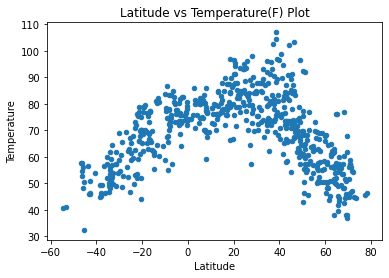

In [13]:
#Using clean_city_data DataFrame, plotting the Latitude vs Temperature values

lat_temp_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                              y = "Temperature",
                                              facecolors ="red",
                                              title="Latitude vs Temperature(F) Plot")

plt.show()

**Assessment of the Latitude vs Temperature Plot**

Regardless of the cities used for this scatter plot, the data will confirm that locations/cities within between -23.5 to 23.5 degrees Latitude will have higher temperatures. Those cities lie in the Torrid Zone of the earth, those cities closer to the equator being hotter.

### Latitude vs. Humidity Plot

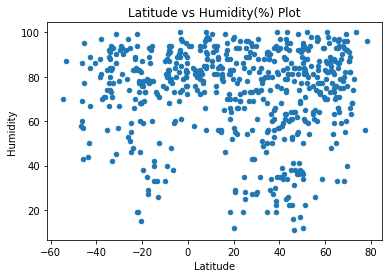

In [14]:
lat_humid_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Humidity",
                                        facecolors ="red",
                                        title="Latitude vs Humidity(%) Plot")
plt.show(lat_humid_plot)

**Assessment of the Latitude vs Humidity Plot**
The Humidity value used in this assessment is Absolute Humidity. The humidity percentage will vary with different Latitude degrees.

### Latitude vs. Cloudiness Plot

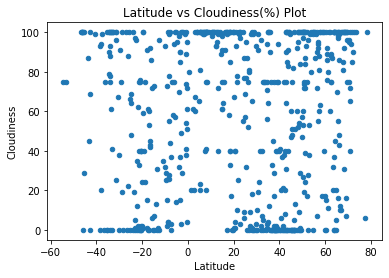

In [15]:
lat_cloud_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Cloudiness",
                                        facecolors ="red",
                                        title="Latitude vs Cloudiness(%) Plot")
plt.show(lat_cloud_plot)

**Assessment of the Latitude vs Cloudiness Plot**

Based on the data there is no correlation between Latitude and Cloudiness conditions. For this reason you will find cloudiness throughout the dataset.

### Latitude vs. Wind Speed Plot

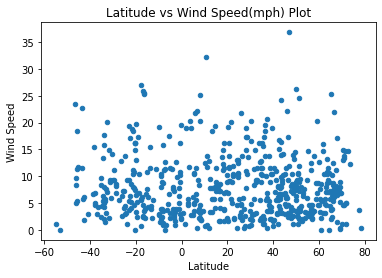

In [16]:
lat_wind_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Wind Speed",
                                        facecolors ="red",
                                        title="Latitude vs Wind Speed(mph) Plot")
plt.show(lat_wind_plot)

**Assessment of the Latitude vs Wind Speed Plot**

Like assessment of the Latitude vs Cloudiness, the data to show the relationship between Latitude and Wind Speed conditions shows no correlation of one to the other.

## Linear Regression

In [17]:
clean_city_data.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Kapaa,25,US,1659650282,66,22.0752,-159.319,83.48,5.01
1,1,Hilo,0,US,1659650061,79,19.7297,-155.090,87.28,8.99


In [18]:
#Create 2 more dataframe from the clean_city_data

#Northern Hemisphere dataframe - cities with Latitude >= 0
north_hemi_df = clean_city_data.loc[(clean_city_data["Latitude"] >= 0), :]
north_hemi_df.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Kapaa,25,US,1659650282,66,22.0752,-159.319,83.48,5.01
1,1,Hilo,0,US,1659650061,79,19.7297,-155.090,87.28,8.99


In [19]:
#Southern Hemisphere dataframe - cities with Latitude < 0
south_hemi_df =clean_city_data.loc[(clean_city_data["Latitude"] < 0), :]
south_hemi_df.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
2,2,Rikitea,97,PF,1659650294,70,-23.1203,-134.9692,70.70,19.44
3,3,Faanui,42,PF,1659650876,78,-16.4833,-151.7500,77.34,25.28


###  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

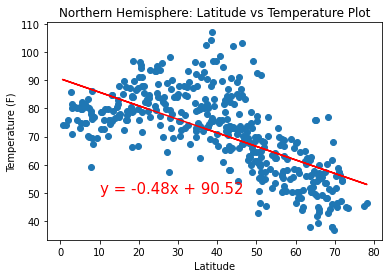

In [20]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Temperature"]

#Regression part
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,50),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Temperature Plot")
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.savefig("images/north_temp_lat.png")
plt.show()

###  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

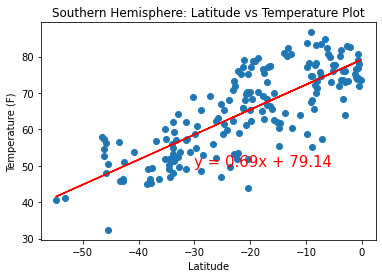

In [21]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-30,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Temperature Plot")
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.savefig("images/south_temp_lat.png")
plt.show()

**Assessment: Northern Hemisphere & Southern Hemisphere - Max Temp vs. Latitude Linear Regression Plot**

The northern hemisphere scatter plot confirms that northern hemisphere locations/cities between 0 to 23.5 degrees Latitude will have higher temperatures There will be a steady decline in temperature as the lalitude increases with a few outliers. 
While the southern hemisphere's scatter plot confirms that southern hemisphere locations/cities between -23.5 and 0 degrees latitude will have higher temperatures with areas with lalitude lower than -23.5 degrees will have lower temperatures. This chart is the reverse of the northern hemisphere, for the southern hemisphere, the temperatures start low and then get higher as the latitude approaches the equator. Positive correlation for these factors

###  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

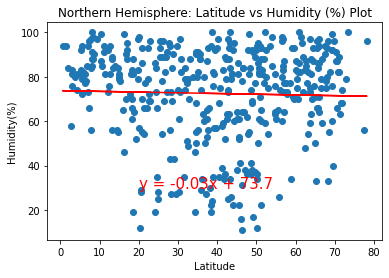

In [22]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,30),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Humidity (%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')
plt.savefig("images/north_humid_lat.png")
plt.show()

###  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

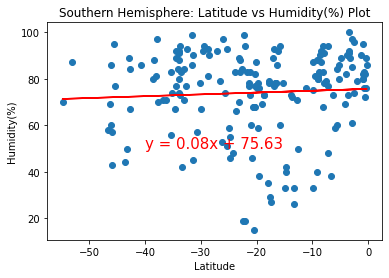

In [23]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-40,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Humidity(%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')
plt.savefig("images/south_humid_lat.png")
plt.show()

**Assessment: Northern Hemisphere & Southern Hemisphere - Humidity vs. Latitude Linear Regression Plot**

When the humidity percentage is high, the hotter a person will feel due to the inability of the body to cool itself via the evaporation of sweat. The humidity will be higher for places in the northern hemisphere than the south.

###  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

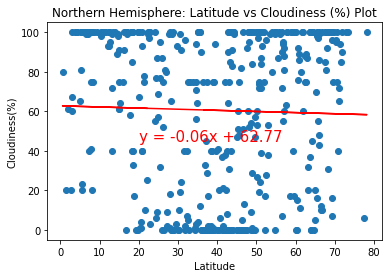

In [24]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,45),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Cloudiness (%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness(%)')
plt.savefig("images/north_cloud_lat.png")
plt.show()

###  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

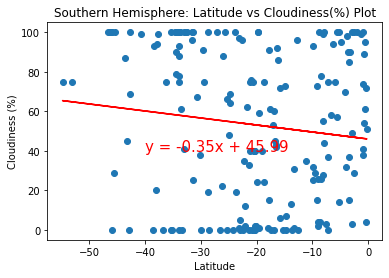

In [25]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-40,40),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Cloudiness(%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.savefig("images/south_cloud_lat.png")
plt.show()

**Assessment: Northern Hemisphere & Southern Hemisphere - Cloudiness vs. Latitude Linear Regression Plot**

The cloudiness percentage is concentrated around latitudes 20-70degress in the north and -30 to 10degrees Latitude in the south.

###  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

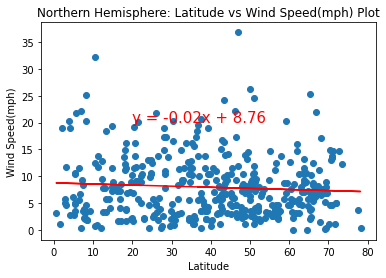

In [26]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,20),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Wind Speed(mph) Plot")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed(mph)')
plt.savefig("images/north_wind_lat.png")
plt.show()

###  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

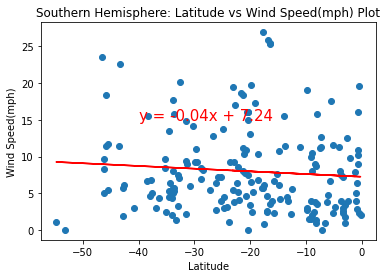

In [27]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-40,15),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Wind Speed(mph) Plot")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed(mph)')
plt.savefig("images/south_wind_lat.png")
plt.show()

**Assessment: Northern Hemisphere & Southern Hemisphere - Wind Speed vs. Latitude Linear Regression Plot**

Based on the points plotted, it would appear that the dataset had more cities in the northern hemisphere. However for both, the average wind speed will be between 7 to 10 mph.
